# Ranking System #

Notebook Summary:
 - Standardisation of Data
 - Weighted Sum of Standardised Data
 - Ranking of Data
 - Analysis and Breakdonw of Top 100 merchants


In [1]:
# for spark functions
from pyspark.sql import SparkSession, functions as f
from pyspark.sql.functions import col
from pyspark.sql.functions import expr

# for standardisation of data
from pyspark.ml.feature import VectorAssembler, MinMaxScaler
from pyspark.sql.functions import udf, lit
from pyspark.sql.types import DoubleType
from pyspark.ml import Pipeline

# for ranking analysis/breakdown
from pyspark.sql.window import Window
import pyspark.sql.functions as F

# for visualisatiuon
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# creating spark session
spark = (
    SparkSession.builder.appName("ranking_system")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config('spark.driver.memory', '3g')   
    .config('spark.executor.memory', '4g')  
    .config('spark.executor.instances', '2')  
    .config('spark.executor.cores', '2')
    .getOrCreate()
)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/10/06 10:35:55 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
# reading in aggregate data set which will be used for ranking system
ranking_df = spark.read.parquet("../../../data/ranking_data_XGB.parquet")

In [4]:
ranking_df.show()

23/10/06 10:36:05 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+------------+--------------------+-------------+------------------+----------------------------------+--------------------------+----------------------------------+--------------------------+----------------------------------------+----------------+---------------------+--------------------------+------------------------------+-------------------------+------------------------+------------------------+--------------------------+-------------------------+-------------------------+-------------------+--------------------------------+---------------------------+------------------+------------------+--------------------+---------------------------------+--------------------+------------------+-------------------------------------+---------------------------------+
|merchant_abn|                name|revenue_level|         take_rate|average_merchant_fraud_probability|number_of_unique_consumers|average_consumer_fraud_probability|number_of_repeat_consumers|average_repeat_transactions_per_cons

# Standardisation 
Standardise the numerical data to then use for weighted ranking system

In [5]:
# Columns to be standardized
numerical_columns = ['take_rate', 'average_merchant_fraud_probability','number_of_unique_consumers', 
                     'average_consumer_fraud_probability','number_of_repeat_consumers',
                     'average_repeat_transactions_per_consumer','number_of_orders','average_cost_of_order',
                     'average_spend_per_consumer','average_monthly_diff_consumers','consumer_diff_over_period',
                     'average_growth_consumers', 'merchant_revenue_rounded','transcation_period_months',
                     'number_of_postcodes','avg_total_weekly_personal_income','avg_total_weekly_fam_income',
                     'avg_median_age','avg_household_size','postcode_reach','avg_num_of_consumers_per_postcode', 
                     'bnpl_maximum_gain', 'predicted_num_of_unique_customers']


# Create a VectorAssembler to assemble the numerical features into a vector
assembler = VectorAssembler(inputCols=numerical_columns, outputCol='features')

# Create a MinMaxScaler to scale the features
scaler = MinMaxScaler(inputCol='features', outputCol='scaled_features')

# Define a UDF to extract elements from the dense vector
extract_feature_udf = udf(lambda vector, i: float(vector[i]), DoubleType())

# Create a Pipeline to chain assembling and scaling stages
pipeline = Pipeline(stages=[assembler, scaler])

# Fit and transform the data using the pipeline
model = pipeline.fit(ranking_df)
scaled_df = model.transform(ranking_df)

# Replace the original columns with MinMax scaled values
for i, col in enumerate(numerical_columns):
    scaled_df = scaled_df.withColumn(col, extract_feature_udf('scaled_features', lit(i)))

# Drop the 'scaled_features' column as it is no longer needed
scaled_df = scaled_df.drop('scaled_features', 'features', 'predicted_num_of_unique_customers_XGB')

# Show the first few rows of the DataFrame with MinMax scaled values
scaled_df.show(truncate=False)

+------------+---------------------------------+-------------+-------------------+----------------------------------+--------------------------+----------------------------------+--------------------------+----------------------------------------+---------------------+---------------------+--------------------------+------------------------------+-------------------------+------------------------+------------------------+--------------------------+-------------------------+-------------------------+--------------------+--------------------------------+---------------------------+-------------------+-------------------+--------------------+---------------------------------+----------------------+---------------------+---------------------------------+
|merchant_abn|name                             |revenue_level|take_rate          |average_merchant_fraud_probability|number_of_unique_consumers|average_consumer_fraud_probability|number_of_repeat_consumers|average_repeat_transactions_per_c

# Weighted Sum of Standardised Numerical Attributes

In [6]:
WEIGHT = [-0.1, # for attributes that have a negative impact on merchant
		  0, # no impact
		  0.01, # min positive impact
		  0.02, 
		  0.05, 
		  0.1, 
		  0.2 # max positive impact
]

# Define the weights for each attribute as a dictionary
attribute_weights = {
	'take_rate': WEIGHT[1],
	'average_merchant_fraud_probability': WEIGHT[0],
	'number_of_unique_consumers': WEIGHT[4], 
	'average_consumer_fraud_probability': WEIGHT[0],
	'number_of_repeat_consumers': WEIGHT[3],
	'average_repeat_transactions_per_consumer': WEIGHT[3],
	'number_of_orders': WEIGHT[4],
	'average_cost_of_order': WEIGHT[5],
	'average_spend_per_consumer': WEIGHT[5],
	'average_monthly_diff_consumers': WEIGHT[1],
	'consumer_diff_over_period': WEIGHT[1],
	'average_growth_consumers': WEIGHT[5], 
	'merchant_revenue_rounded': WEIGHT[1],
	'transcation_period_months': WEIGHT[1],
	'number_of_postcodes': WEIGHT[1],
	'avg_total_weekly_personal_income': WEIGHT[2],
	'avg_total_weekly_fam_income': WEIGHT[2],
	'avg_median_age': WEIGHT[2],
	'avg_household_size': WEIGHT[2],
	'postcode_reach': WEIGHT[2],
	'avg_num_of_consumers_per_postcode': WEIGHT[2],
	'bnpl_maximum_gain' : WEIGHT[6],
	'predicted_num_of_unique_customers': WEIGHT[5]
}

# Create a SQL expression to calculate the weighted sum
weighted_sum_expr = " + ".join([f"{column_name} * {attribute_weights[column_name]}" for column_name in attribute_weights.keys()])

# Calculate the weighted sum using selectExpr
scaled_df_with_weighted_sum = scaled_df.selectExpr("*", f"({weighted_sum_expr}) as weighted_sum")

# Show the DataFrame with the new weighted sum column
scaled_df_with_weighted_sum.show()

+------------+--------------------+-------------+-------------------+----------------------------------+--------------------------+----------------------------------+--------------------------+----------------------------------------+--------------------+---------------------+--------------------------+------------------------------+-------------------------+------------------------+------------------------+--------------------------+-------------------------+-------------------------+--------------------+--------------------------------+---------------------------+-------------------+-------------------+--------------------+---------------------------------+--------------------+--------------------+---------------------------------+--------------------+
|merchant_abn|                name|revenue_level|          take_rate|average_merchant_fraud_probability|number_of_unique_consumers|average_consumer_fraud_probability|number_of_repeat_consumers|average_repeat_transactions_per_consumer| 

Using the ***'weighted_sum'*** attribute calculated above, we now reduce the merchants to find the ***TOP 100*** merchants. 

In [15]:
# Rank the entries by the "weighted_sum" column in descending order
scaled_ranked_df = scaled_df_with_weighted_sum.orderBy("weighted_sum", ascending=False)

# Limit the result to the top 100 entries
top_100_entries = scaled_ranked_df.limit(100)

cols_to_drop = ['take_rate', 'average_merchant_fraud_probability','number_of_unique_consumers', 
				'average_consumer_fraud_probability','number_of_repeat_consumers',
				'average_repeat_transactions_per_consumer','number_of_orders','average_cost_of_order',
				'average_spend_per_consumer','average_monthly_diff_consumers','consumer_diff_over_period',
				'average_growth_consumers', 'merchant_revenue_rounded','transcation_period_months',
				'number_of_postcodes','avg_total_weekly_personal_income','avg_total_weekly_fam_income',
				'avg_median_age','avg_household_size','postcode_reach','avg_num_of_consumers_per_postcode', 
				'bnpl_maximum_gain', 'predicted_num_of_unique_customers', 'revenue_level', 
				'first_recorded_transaction', 'last_recorded_transaction','segment']

# dropping the standardised versions of the numerical attributes
top_100_entries = top_100_entries.drop(*cols_to_drop)

# adding rank attribute to dataframe
window_spec = Window.orderBy(F.desc("weighted_sum"))
top_100_entries = top_100_entries.withColumn("rank", F.row_number().over(window_spec))


# Show the top 100 entries
top_100_entries.show()


23/10/06 10:58:46 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/10/06 10:58:47 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/10/06 10:58:47 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+------------+--------------------+-------------------+----+
|merchant_abn|                name|       weighted_sum|rank|
+------------+--------------------+-------------------+----+
| 86578477987|   Leo In Consulting|0.47125780238975146|   1|
| 45629217853|    Lacus Consulting|  0.451307745945532|   2|
| 89726005175| Est Nunc Consulting| 0.4317252346630714|   3|
| 32361057556|Orci In Consequat...| 0.4192811668061549|   4|
| 21439773999|Mauris Non Institute| 0.4152648366001994|   5|
| 64403598239|Lobortis Ultrices...|0.40910969007785986|   6|
| 49891706470|Non Vestibulum In...|  0.404759817009859|   7|
| 48534649627|Dignissim Maecena...|0.39018892198342303|   8|
| 43186523025|Lorem Ipsum Sodal...| 0.3886430081174265|   9|
| 94493496784|Dictum Phasellus ...| 0.3868594547318504|  10|
| 72472909171|   Nullam Consulting|0.37516884067112705|  11|
| 79417999332|Phasellus At Company|0.37202921670114103|  12|
| 24852446429|      Erat Vitae LLP|0.36706581973160607|  13|
| 49322182190|Gravida Ma

# Top 10 per Segment
Now we want to find the ***TOP 10*** merchants per segment. 

In [8]:
# Assuming you have a DataFrame named scaled_df_with_weighted_sum
window_spec = Window.partitionBy("segment").orderBy(F.col("weighted_sum").desc())

ranked_df = scaled_df_with_weighted_sum.withColumn("rank", F.rank().over(window_spec))
top_10_entries = ranked_df.filter(F.col("rank") <= 10).select("rank", "merchant_abn", "name", "weighted_sum", "segment")

In [9]:
# Iterate through distinct segments and print top 10 entries for each
distinct_segments = scaled_df_with_weighted_sum.select("segment").distinct().rdd.flatMap(lambda x: x).collect()

for segment in distinct_segments:
    print(f"Top 10 entries for segment '{segment}':")
    top_10_entries.filter(F.col("segment") == segment).show()

Top 10 entries for segment 'garden_and_furnishings':


+----+------------+--------------------+-------------------+--------------------+
|rank|merchant_abn|                name|       weighted_sum|             segment|
+----+------------+--------------------+-------------------+--------------------+
|   1| 89726005175| Est Nunc Consulting| 0.4317252346630714|garden_and_furnis...|
|   2| 49891706470|Non Vestibulum In...|  0.404759817009859|garden_and_furnis...|
|   3| 43186523025|Lorem Ipsum Sodal...| 0.3886430081174265|garden_and_furnis...|
|   4| 24852446429|      Erat Vitae LLP|0.36706581973160607|garden_and_furnis...|
|   5| 64203420245|  Pede Nonummy Corp.| 0.3477357722182641|garden_and_furnis...|
|   6| 76767266140|Phasellus At Limited| 0.3184214884305683|garden_and_furnis...|
|   7| 79827781481|     Amet Risus Inc.| 0.2959307270416546|garden_and_furnis...|
|   8| 38090089066|Interdum Feugiat ...| 0.2872552932789445|garden_and_furnis...|
|   9| 49212265466|      Auctor Company|0.28682706728830454|garden_and_furnis...|
|  10| 423550285

+----+------------+--------------------+-------------------+--------------------+
|rank|merchant_abn|                name|       weighted_sum|             segment|
+----+------------+--------------------+-------------------+--------------------+
|   1| 86578477987|   Leo In Consulting|0.47125780238975146|antiques_and_jewe...|
|   2| 49322182190|Gravida Mauris In...|0.35907448932032315|antiques_and_jewe...|
|   3| 68559320474|Aliquam Auctor As...| 0.2765812008776026|antiques_and_jewe...|
|   4| 23338656015|         Iaculis LLC| 0.2469169228902756|antiques_and_jewe...|
|   5| 29616684420|       Tellus Id LLC|0.23627951902425104|antiques_and_jewe...|
|   6| 98166254020|Magna Sed Industries| 0.2233592263802504|antiques_and_jewe...|
|   7| 81761494572|Nulla Facilisis I...|0.22333724140815098|antiques_and_jewe...|
|   8| 71528203369|Ipsum Primis Asso...|0.21125867251178326|antiques_and_jewe...|
|   9| 62224020443|Hendrerit A Corpo...|0.20393022280070738|antiques_and_jewe...|
|  10| 766261198

+----+------------+--------------------+-------------------+--------------------+
|rank|merchant_abn|                name|       weighted_sum|             segment|
+----+------------+--------------------+-------------------+--------------------+
|   1| 48534649627|Dignissim Maecena...|0.39018892198342303|specialized_services|
|   2| 96680767841|      Ornare Limited| 0.3424802495972929|specialized_services|
|   3| 46804135891|Suspendisse Dui C...|0.33691441744957495|specialized_services|
|   4| 13514558491|   Magna Praesent PC|0.24985925883458932|specialized_services|
|   5| 22033359776|Suspendisse Non L...|0.23222634909028514|specialized_services|
|   6| 31385641294|    Semper Auctor PC|0.22336949568974648|specialized_services|
|   7| 21359184622|         Sit Amet PC|  0.215707305169652|specialized_services|
|   8| 11566786699|Euismod Et Institute|0.20223271679347066|specialized_services|
|   9| 41251795489|Ultricies Sem Lim...|0.19810050021701303|specialized_services|
|  10| 181583872

+----+------------+--------------------+-------------------+--------------------+
|rank|merchant_abn|                name|       weighted_sum|             segment|
+----+------------+--------------------+-------------------+--------------------+
|   1| 21439773999|Mauris Non Institute| 0.4152648366001994|tech_and_electronics|
|   2| 72472909171|   Nullam Consulting|0.37516884067112705|tech_and_electronics|
|   3| 49505931725|Suspendisse Ac As...|0.32555042921686084|tech_and_electronics|
|   4| 68216911708|Placerat Eget Ven...| 0.3242976532452428|tech_and_electronics|
|   5| 35909341340|Arcu Sed Eu Incor...| 0.3188683506299205|tech_and_electronics|
|   6| 94690988633|     Eu Placerat LLC|0.28762144709787957|tech_and_electronics|
|   7| 67400260923|         Eleifend PC|0.28657193947468695|tech_and_electronics|
|   8| 58454491168|  Diam At Foundation|  0.283270690891192|tech_and_electronics|
|   9| 80518954462|Neque Sed Dictum ...| 0.2612532221007601|tech_and_electronics|
|  10| 454334764

+----+------------+--------------------+-------------------+------------------+
|rank|merchant_abn|                name|       weighted_sum|           segment|
+----+------------+--------------------+-------------------+------------------+
|   1| 45629217853|    Lacus Consulting|  0.451307745945532|retail_and_novelty|
|   2| 32361057556|Orci In Consequat...| 0.4192811668061549|retail_and_novelty|
|   3| 64403598239|Lobortis Ultrices...|0.40910969007785986|retail_and_novelty|
|   4| 94493496784|Dictum Phasellus ...| 0.3868594547318504|retail_and_novelty|
|   5| 79417999332|Phasellus At Company|0.37202921670114103|retail_and_novelty|
|   6| 60956456424|Ultricies Digniss...| 0.3501150841759994|retail_and_novelty|
|   7| 63290521567|Vehicula Pellente...| 0.3463239481366522|retail_and_novelty|
|   8| 98973094975|   Ornare Fusce Inc.| 0.3338276486549131|retail_and_novelty|
|   9| 80324045558|Ipsum Dolor Sit C...|0.29818523912212846|retail_and_novelty|
|  10| 81219314324|    Faucibus Leo Ltd|

# Visualising Top 100

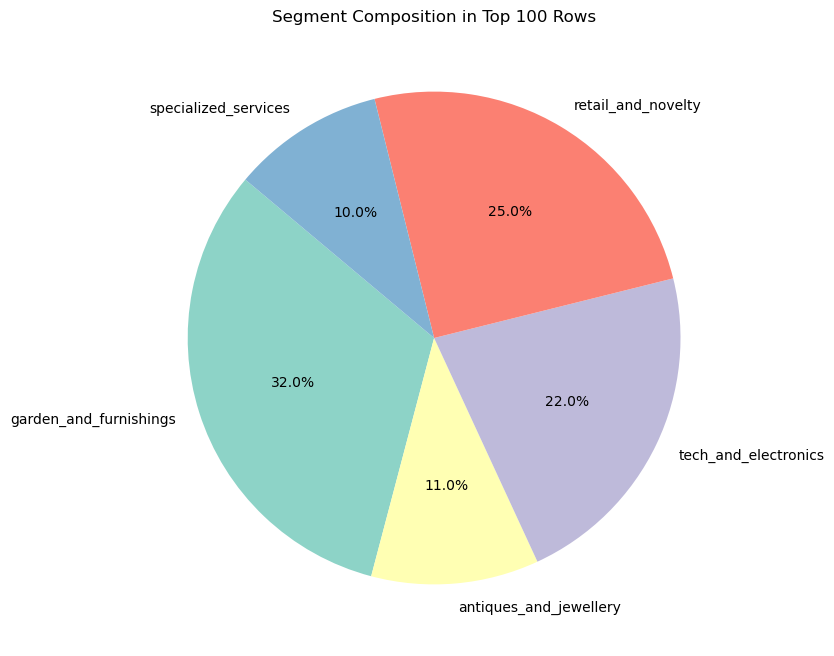

In [13]:
# Group by segment and count the occurrences of each segment in the top 100 scaled_df
top_100_agg_segments = top_100_entries.groupBy("segment").agg(
    f.count("*").alias("segment_count")
)

# Convert the aggregated data to a Pandas DataFrame for visualization
top_100_segments_pandas = top_100_agg_segments.toPandas()

# Plotting
plt.figure(figsize=(12, 8))
plt.pie(top_100_segments_pandas["segment_count"], labels=top_100_segments_pandas["segment"], autopct='%1.1f%%', startangle=140, colors=sns.color_palette("Set3", len(top_100_segments_pandas)))
plt.title('Segment Composition in Top 100 Rows')
plt.show()

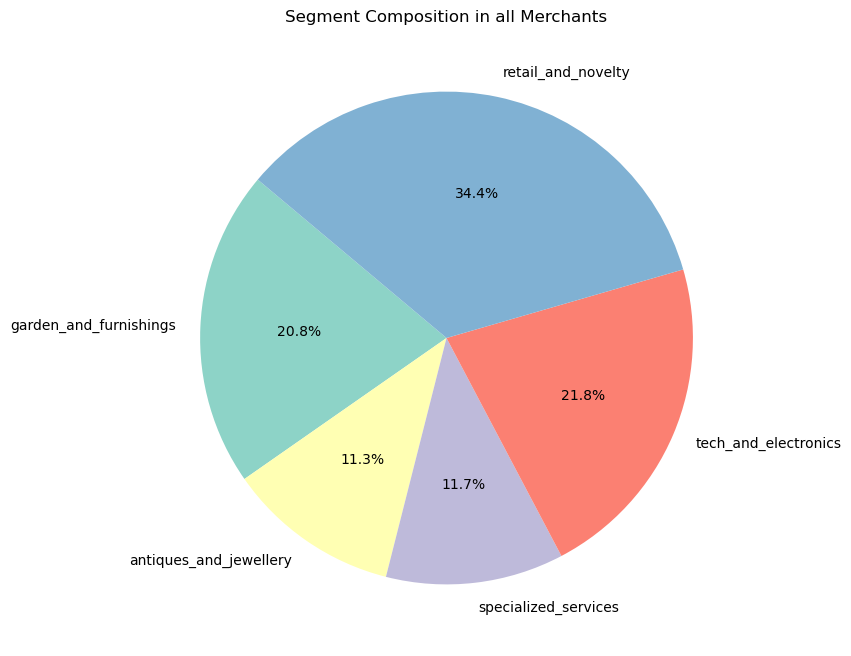

In [17]:
# Group by segment and count the occurrences of each segment in the top 100 scaled_df
all_agg_segments = ranking_df.groupBy("segment").agg(
    f.count("*").alias("segment_count")
)

# Convert the aggregated data to a Pandas DataFrame for visualization
all_segments_pandas = all_agg_segments.toPandas()

# Plotting
plt.figure(figsize=(12, 8))
plt.pie(all_segments_pandas["segment_count"], labels=all_segments_pandas["segment"], autopct='%1.1f%%', startangle=140, colors=sns.color_palette("Set3", len(all_segments_pandas)))
plt.title('Segment Composition in all Merchants')
plt.show()

In [20]:
numerical_columns = ['weighted_sum', 'average_merchant_fraud_probability',
					 'number_of_unique_consumers','average_consumer_fraud_probability',
					 'number_of_repeat_consumers','average_repeat_transactions_per_consumer',
					 'number_of_orders','average_cost_of_order','average_spend_per_consumer',
					 'average_growth_consumers','avg_total_weekly_personal_income',
					 'avg_total_weekly_fam_income', 'avg_median_age','avg_household_size',
					 'postcode_reach','avg_num_of_consumers_per_postcode','bnpl_maximum_gain',
					 'predicted_num_of_unique_customers']

numerical_columns2 = ['weighted_sum', 'average_merchant_fraud_probability']

# Join 'top_100_entries' with 'ranking_df' on the 'merchant_abn' column 
# this is done so that all the true values for the attributes are put back
top_100_entries = top_100_entries.join(ranking_df, on="merchant_abn", how="inner")

top_100_entries = top_100_entries.orderBy("rank")

top_100_pandas = top_100_entries.toPandas()

Exception in thread "serve-DataFrame" java.net.SocketTimeoutException: Accept timed out
	at java.net.PlainSocketImpl.socketAccept(Native Method)
	at java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:535)
	at java.net.ServerSocket.implAccept(ServerSocket.java:545)
	at java.net.ServerSocket.accept(ServerSocket.java:513)
	at org.apache.spark.security.SocketAuthServer$$anon$1.run(SocketAuthServer.scala:65)
23/10/06 11:19:36 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/10/06 11:19:36 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


In [21]:
top_100_pandas.head(100)

,merchant_abn,name,weighted_sum,rank,name,revenue_level,take_rate,average_merchant_fraud_probability,number_of_unique_consumers,average_consumer_fraud_probability,...,avg_total_weekly_personal_income,avg_total_weekly_fam_income,avg_median_age,avg_household_size,postcode_reach,avg_num_of_consumers_per_postcode,segment,bnpl_maximum_gain,predicted_num_of_unique_customers_XGB,predicted_num_of_unique_customers
0,86578477987,Leo In Consulting,0.471258,1,Leo In Consulting,a,6.43,0.000000,20115,0.043976,...,790.122033,1978.244362,43.121872,2.458153,1.000000,86.325123,antiques_and_jewellery,512673.732572,19693.359375,19693.0
1,45629217853,Lacus Consulting,0.451308,2,Lacus Consulting,a,6.98,0.000000,20115,0.042365,...,790.481580,1978.467608,43.092361,2.459781,1.000000,72.300493,retail_and_novelty,490015.776377,19693.359375,19693.0
2,89726005175,Est Nunc Consulting,0.431725,3,Est Nunc Consulting,a,6.01,0.000000,20114,0.044472,...,789.911948,1977.191795,43.089758,2.458121,1.000000,68.294430,garden_and_furnishings,446556.897702,19693.359375,19693.0
3,32361057556,Orci In Consequat Corporation,0.419281,4,Orci In Consequat Corporation,a,6.61,0.000000,19535,0.045323,...,790.882822,1978.125145,43.099313,2.456252,1.000000,27.181887,retail_and_novelty,521025.675549,19005.283203,19005.0
4,21439773999,Mauris Non Institute,0.415265,5,Mauris Non Institute,a,6.10,0.127016,19979,0.044972,...,791.310804,1980.926029,43.088142,2.457653,0.999621,38.196740,tech_and_electronics,480512.900068,19846.490234,19846.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,41251795489,Ultricies Sem Limited,0.198101,96,Ultricies Sem Limited,c,2.91,0.000000,16349,0.045325,...,787.872358,1972.050056,43.159247,2.456717,0.999242,12.844900,specialized_services,29301.376356,16205.417969,16205.0
96,15560455575,Morbi Accumsan Laoreet Industries,0.197981,97,Morbi Accumsan Laoreet Industries,b,4.08,0.000000,14090,0.035753,...,792.431565,1982.897194,43.067901,2.458075,0.997726,9.243069,tech_and_electronics,87150.976682,14138.594727,14139.0
97,18158387243,Nec Tellus Ltd,0.194539,98,Nec Tellus Ltd,c,2.03,0.264597,9903,0.087590,...,790.816588,1975.538402,42.989049,2.460801,0.980674,5.257342,specialized_services,158481.284548,9934.205078,9934.0
98,63465140133,Vitae Odio Limited,0.193431,99,Vitae Odio Limited,b,3.68,0.000000,15624,0.055129,...,791.277300,1981.574980,43.104900,2.455824,0.997726,11.526016,tech_and_electronics,39418.899947,16047.105469,16047.0


/Users/jackolivier/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jackolivier/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jackolivier/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


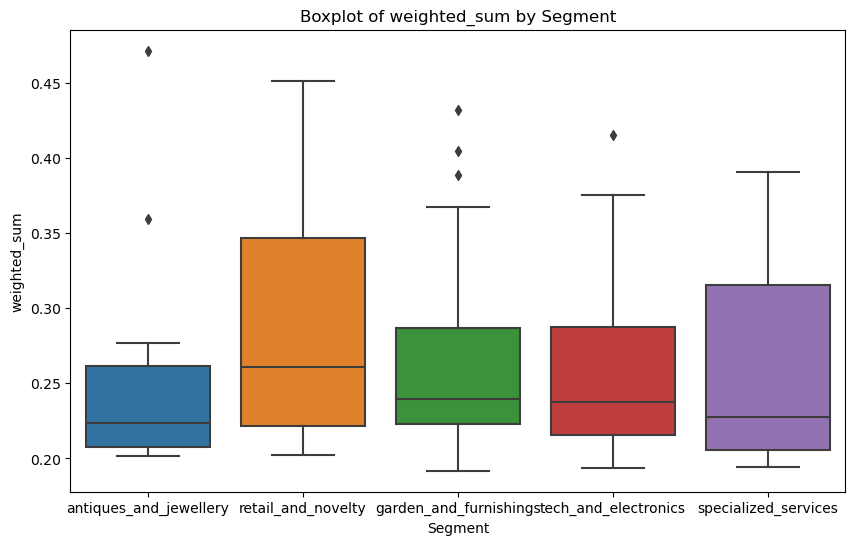

/Users/jackolivier/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jackolivier/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jackolivier/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


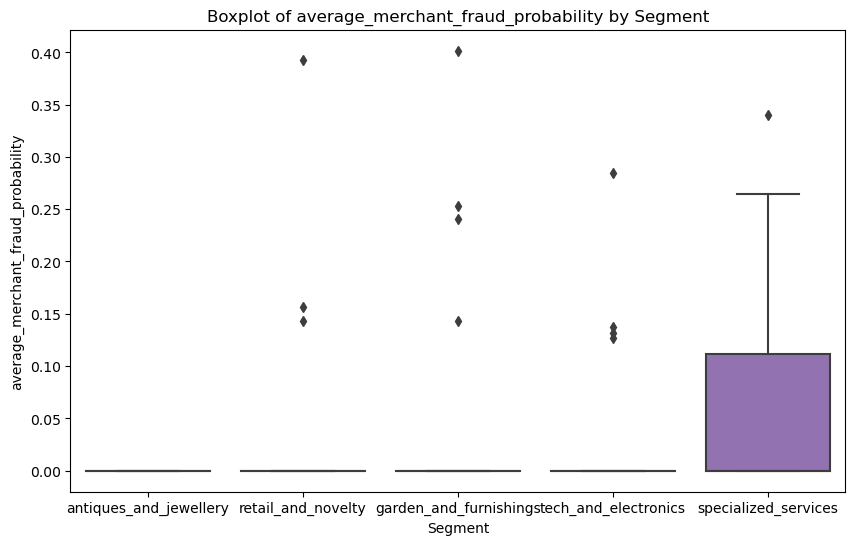

/Users/jackolivier/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jackolivier/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jackolivier/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


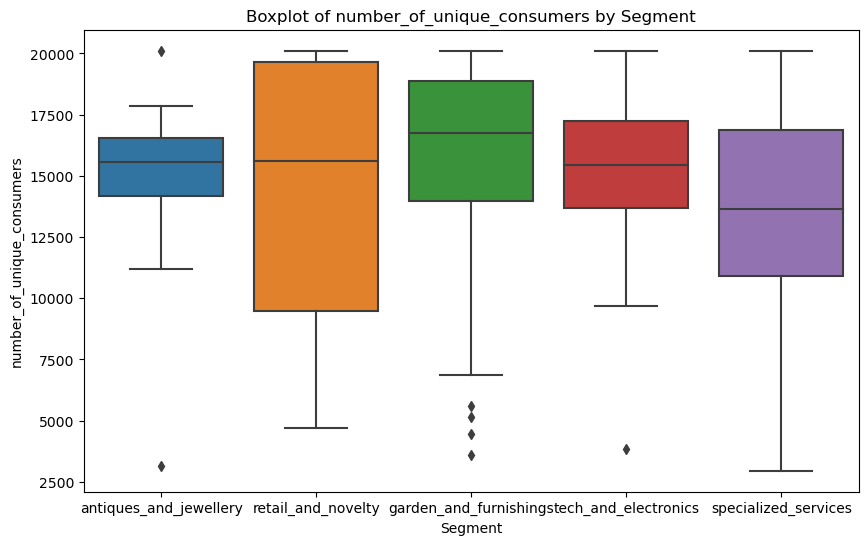

/Users/jackolivier/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jackolivier/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jackolivier/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


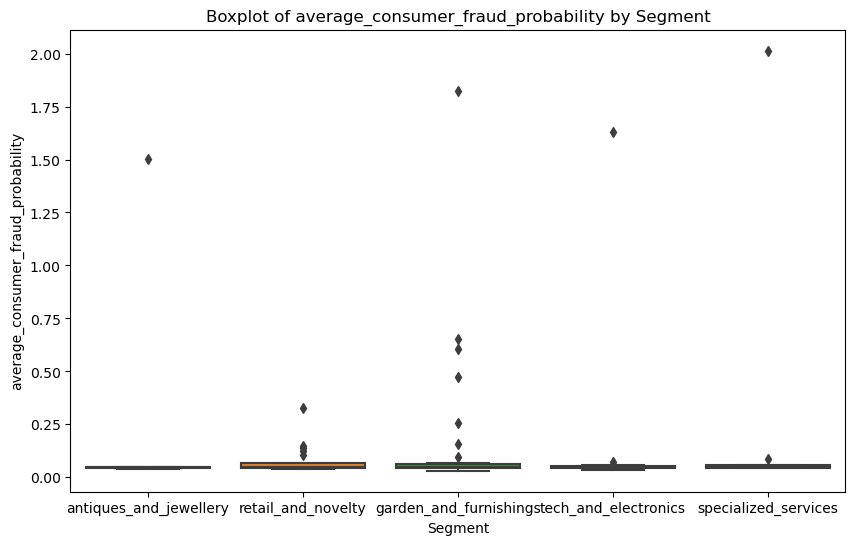

/Users/jackolivier/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jackolivier/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jackolivier/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


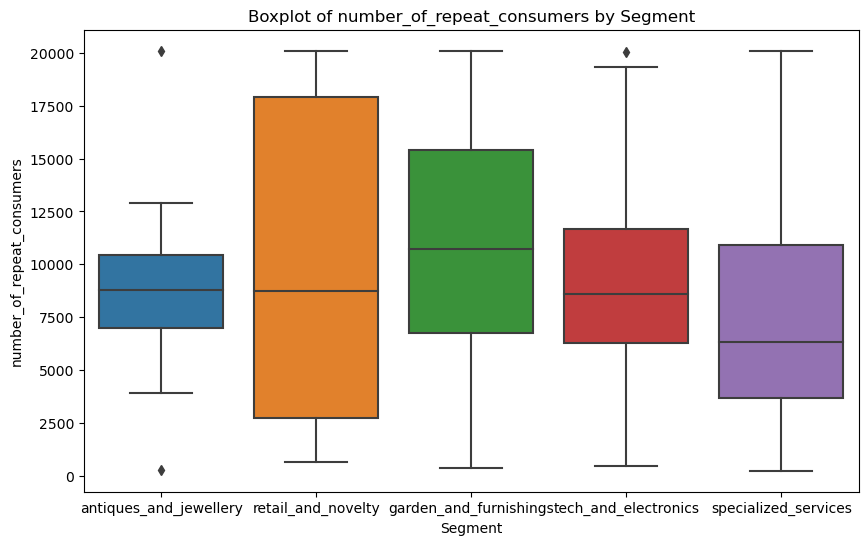

/Users/jackolivier/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jackolivier/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jackolivier/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


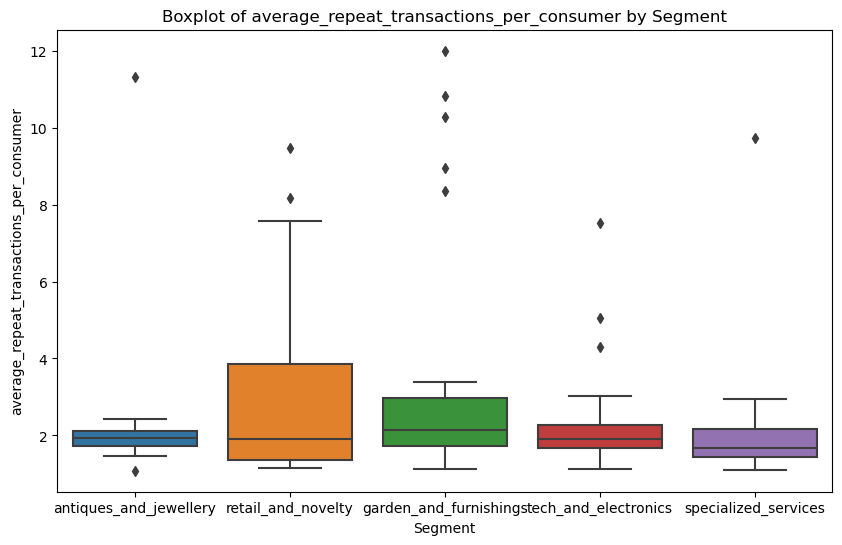

/Users/jackolivier/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jackolivier/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jackolivier/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


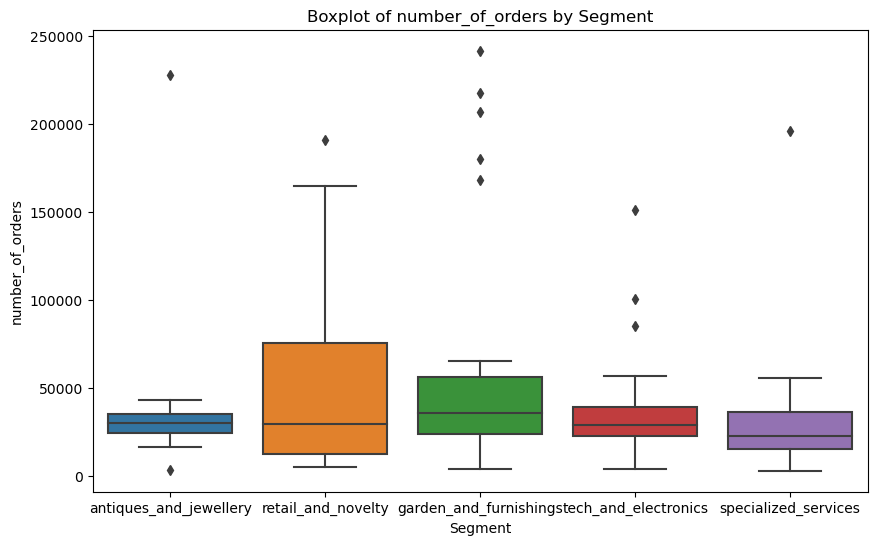

/Users/jackolivier/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jackolivier/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jackolivier/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


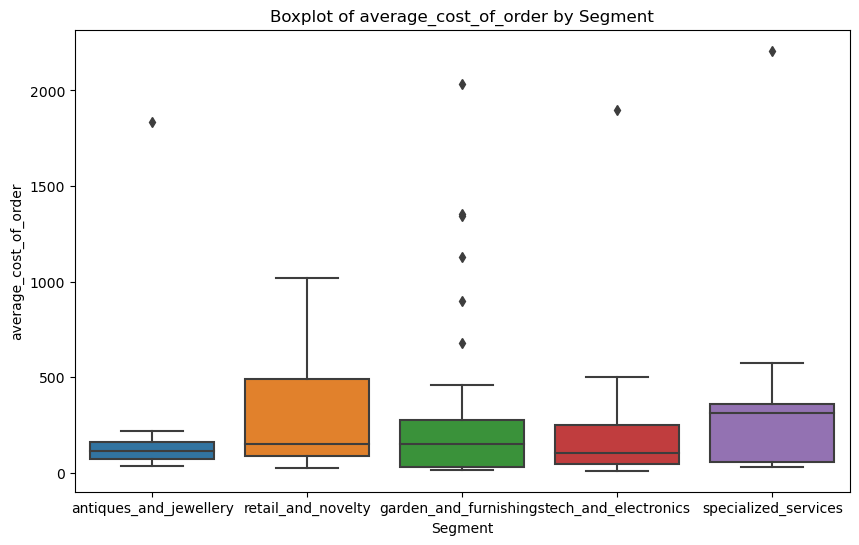

/Users/jackolivier/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jackolivier/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jackolivier/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


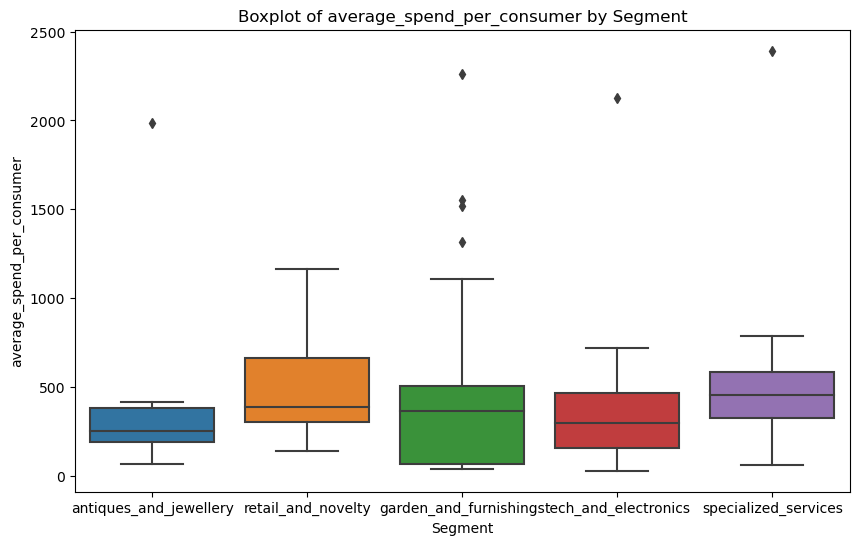

/Users/jackolivier/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jackolivier/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jackolivier/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


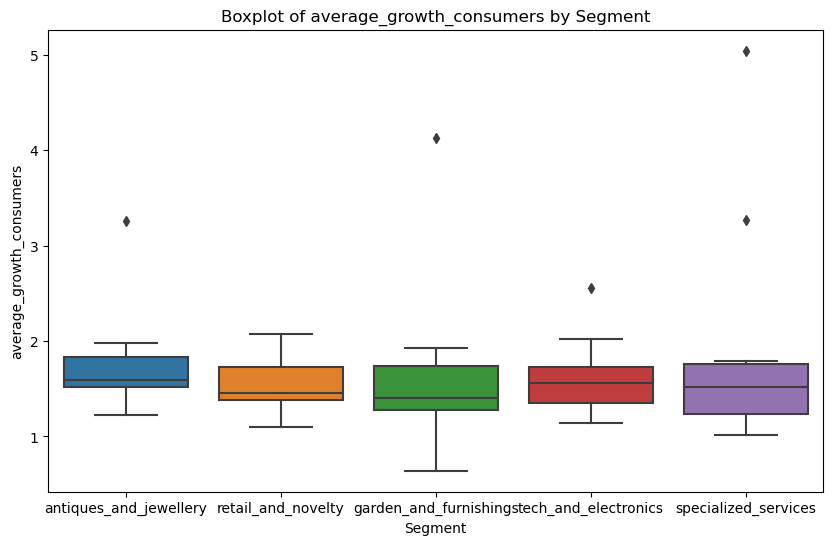

/Users/jackolivier/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jackolivier/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jackolivier/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


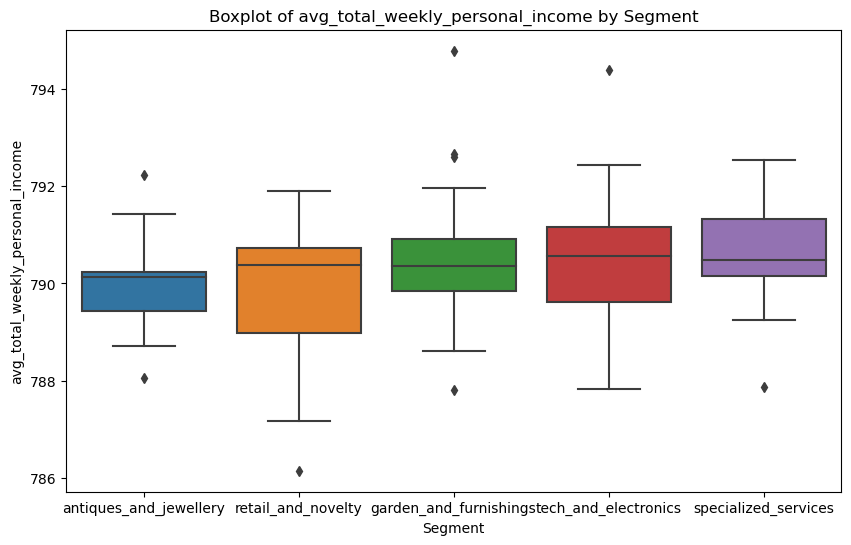

/Users/jackolivier/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jackolivier/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jackolivier/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


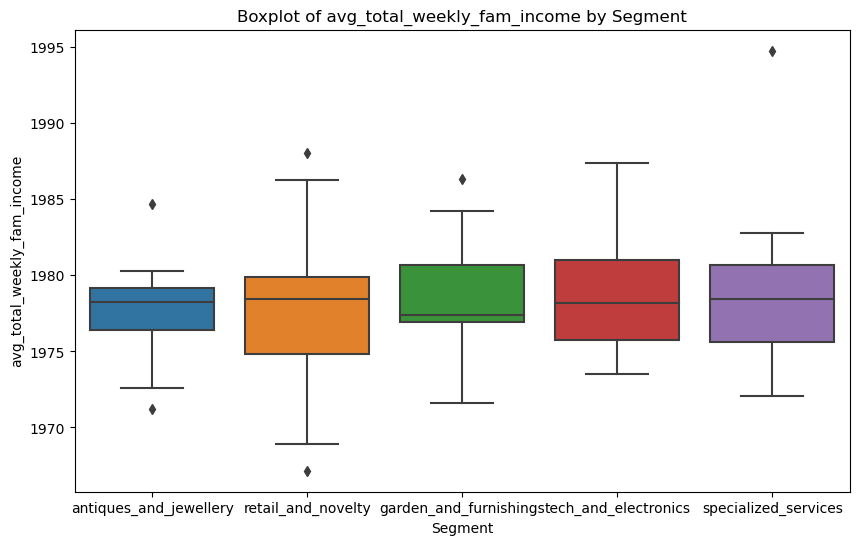

/Users/jackolivier/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jackolivier/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jackolivier/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


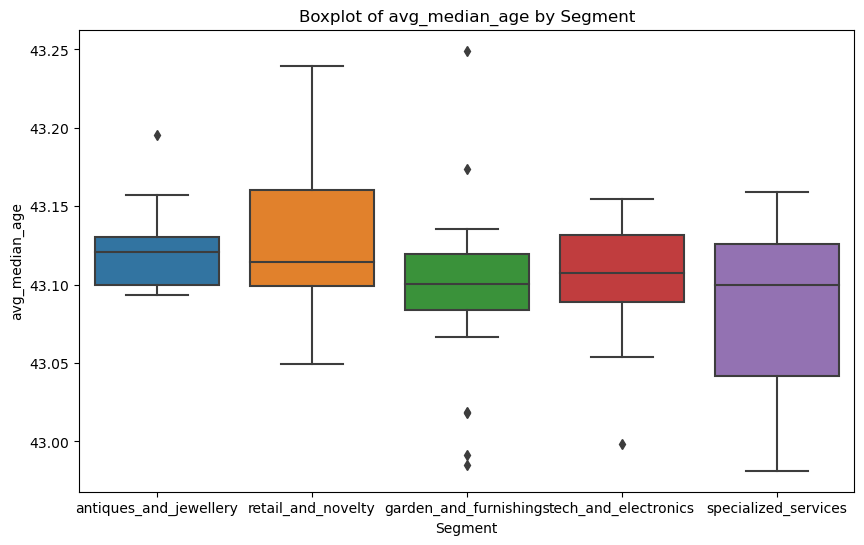

/Users/jackolivier/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jackolivier/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jackolivier/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


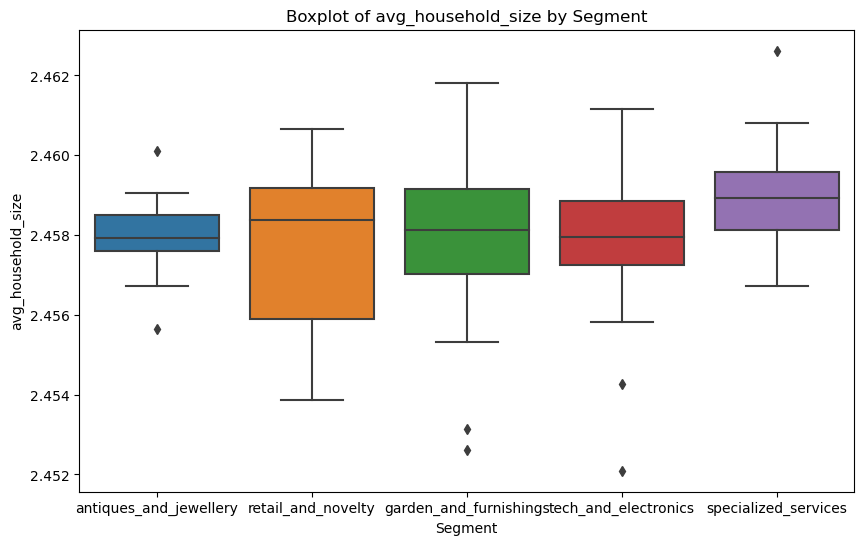

/Users/jackolivier/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jackolivier/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jackolivier/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


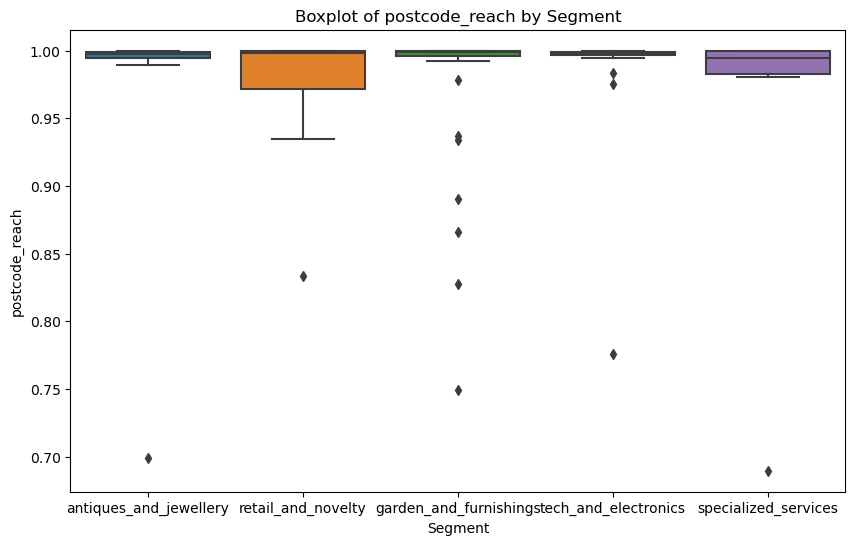

/Users/jackolivier/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jackolivier/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jackolivier/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


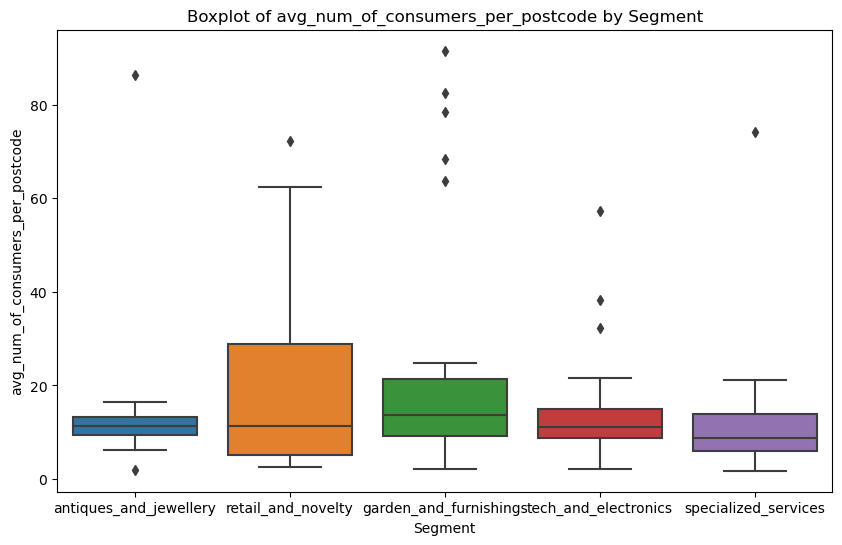

/Users/jackolivier/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jackolivier/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jackolivier/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


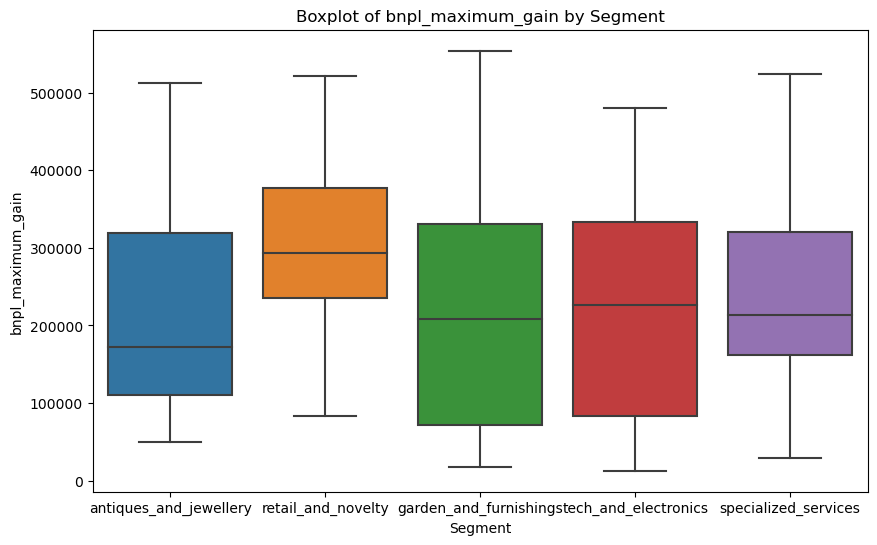

/Users/jackolivier/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jackolivier/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jackolivier/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


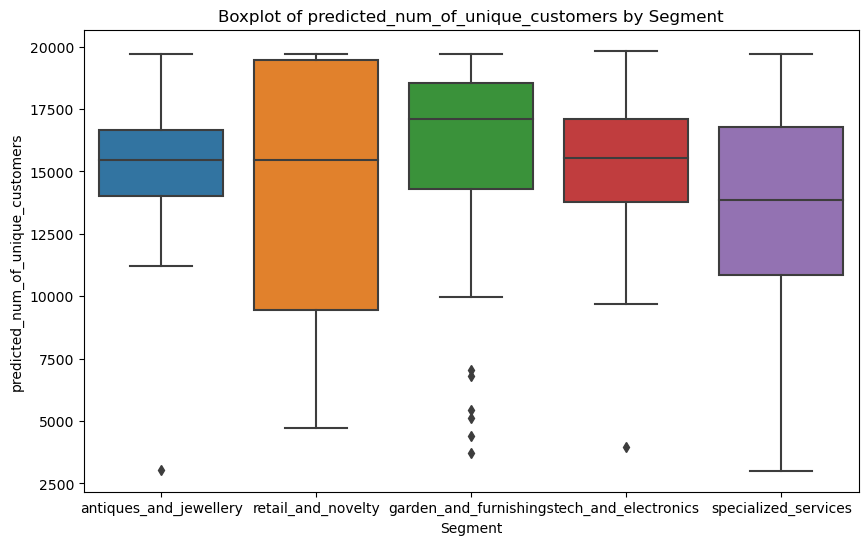

In [56]:
# boxplots comparing between segments for each segment

for attribute in numerical_columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='segment', y=attribute, data=top_100_pandas)
    plt.xlabel('Segment')
    plt.ylabel(attribute)
    plt.title(f'Boxplot of {attribute} by Segment')
    plt.show()

/Users/jackolivier/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jackolivier/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jackolivier/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jackolivier/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstan

<Figure size 1200x800 with 0 Axes>

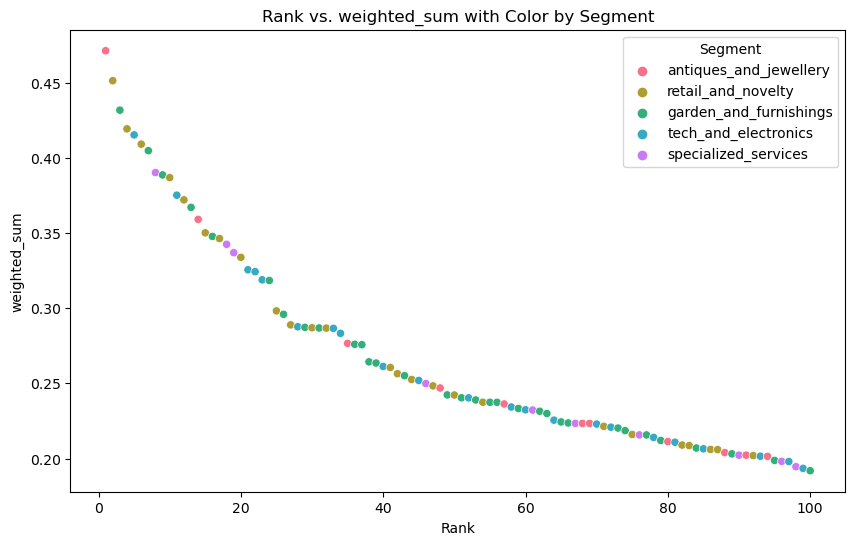

/Users/jackolivier/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jackolivier/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jackolivier/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jackolivier/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstan

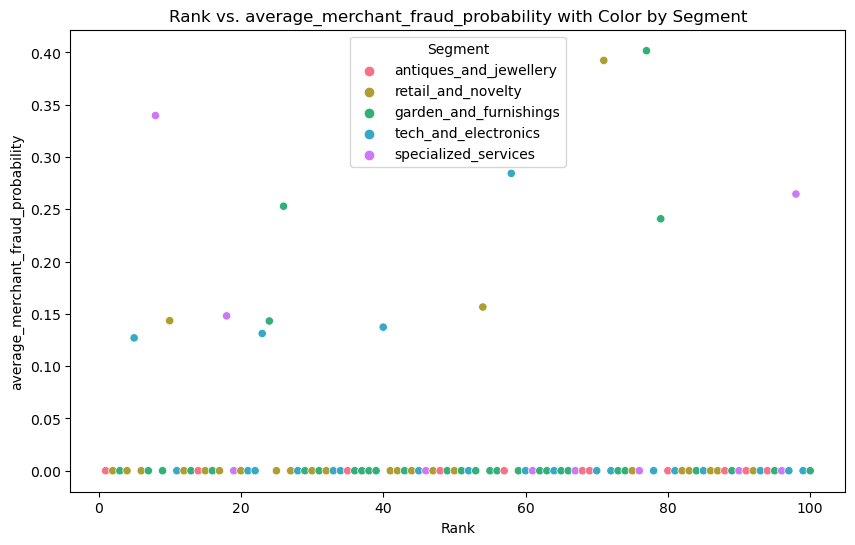

/Users/jackolivier/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jackolivier/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jackolivier/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jackolivier/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstan

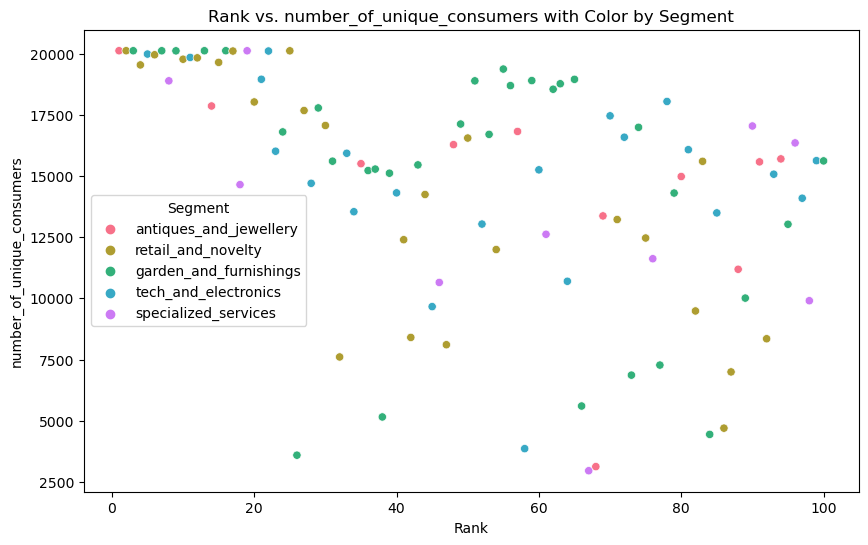

/Users/jackolivier/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jackolivier/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jackolivier/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jackolivier/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstan

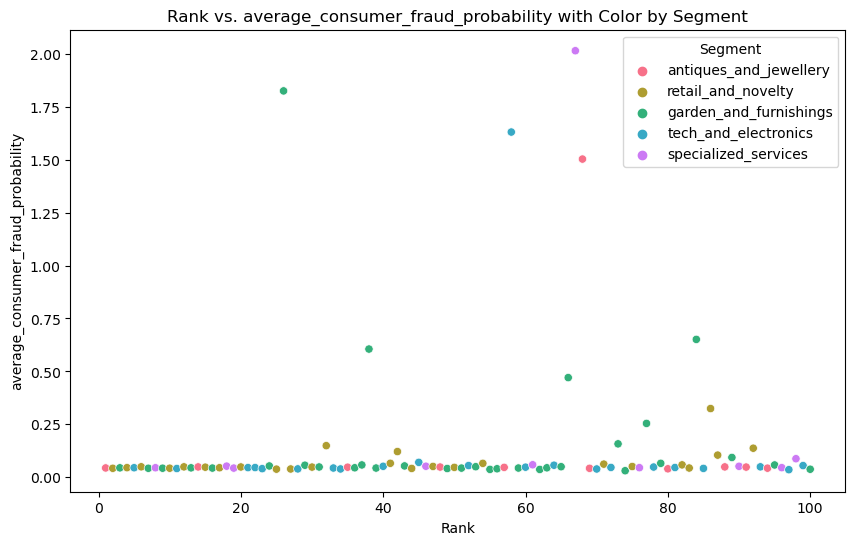

/Users/jackolivier/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jackolivier/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jackolivier/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jackolivier/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstan

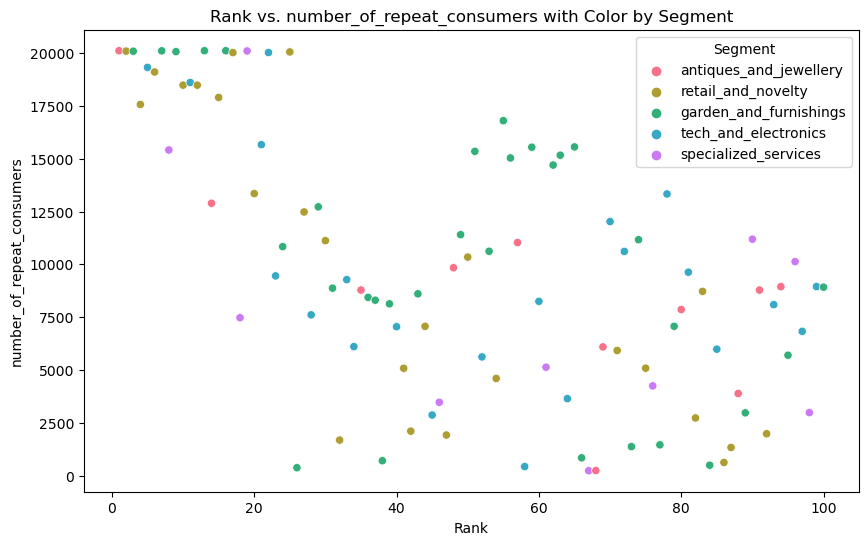

/Users/jackolivier/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jackolivier/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jackolivier/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jackolivier/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstan

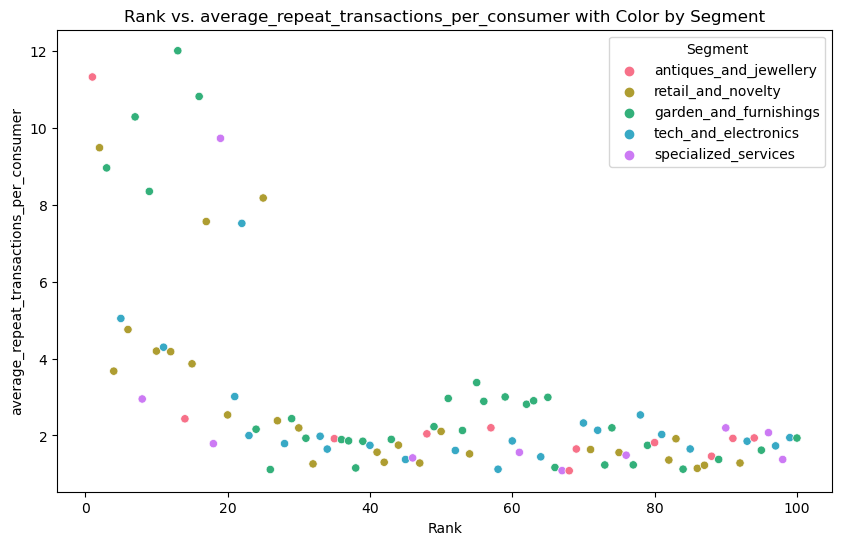

/Users/jackolivier/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jackolivier/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jackolivier/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jackolivier/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstan

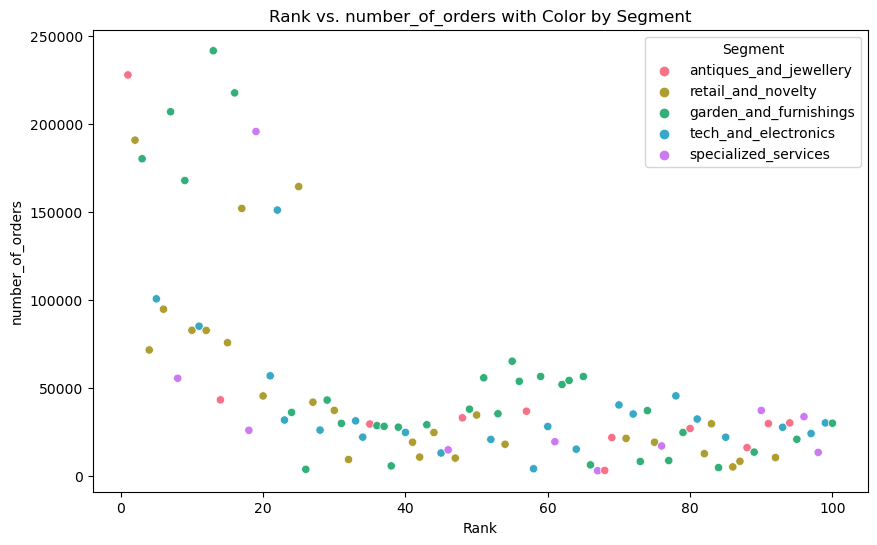

/Users/jackolivier/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jackolivier/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jackolivier/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jackolivier/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstan

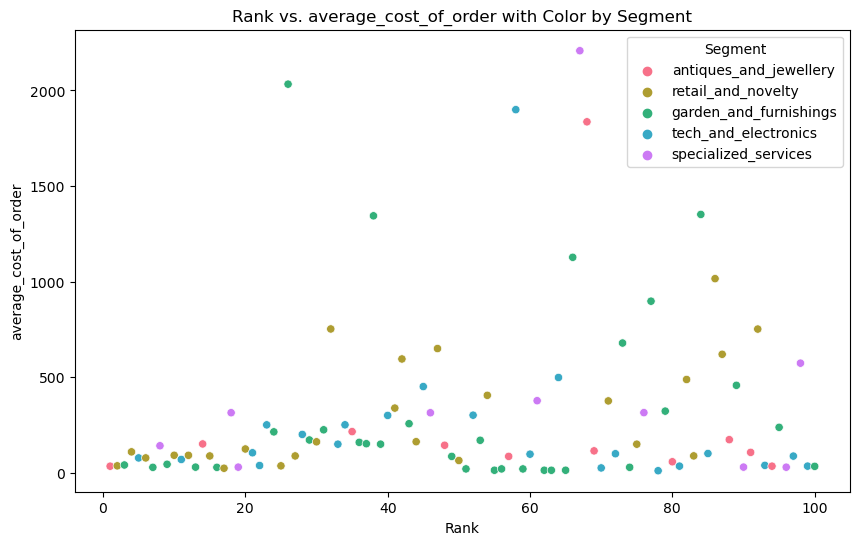

/Users/jackolivier/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jackolivier/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jackolivier/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jackolivier/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstan

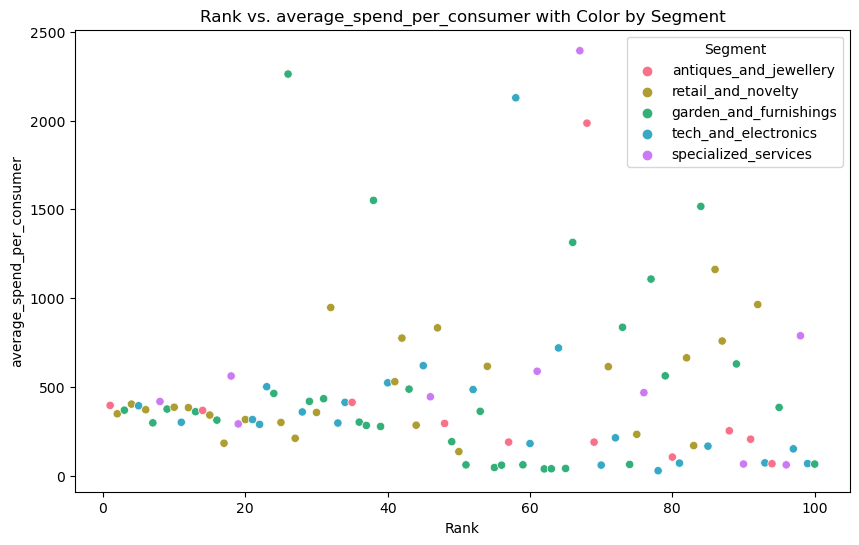

/Users/jackolivier/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jackolivier/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jackolivier/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jackolivier/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstan

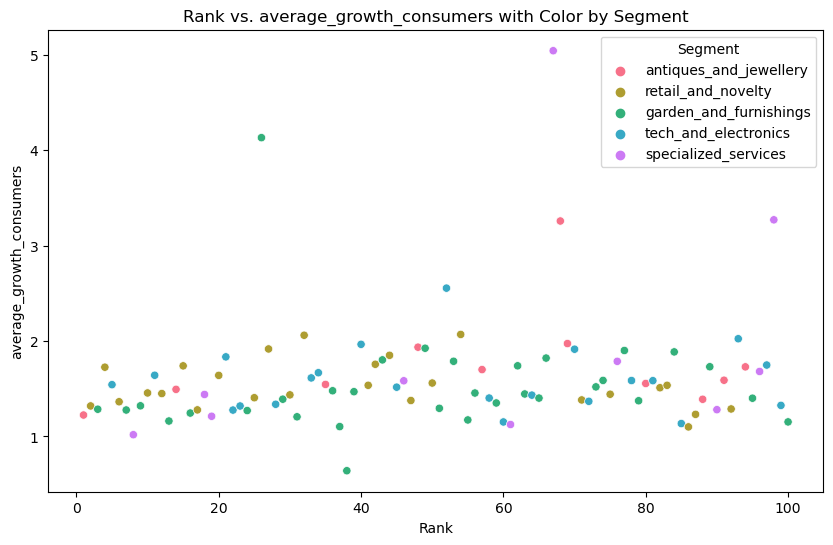

/Users/jackolivier/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jackolivier/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jackolivier/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jackolivier/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstan

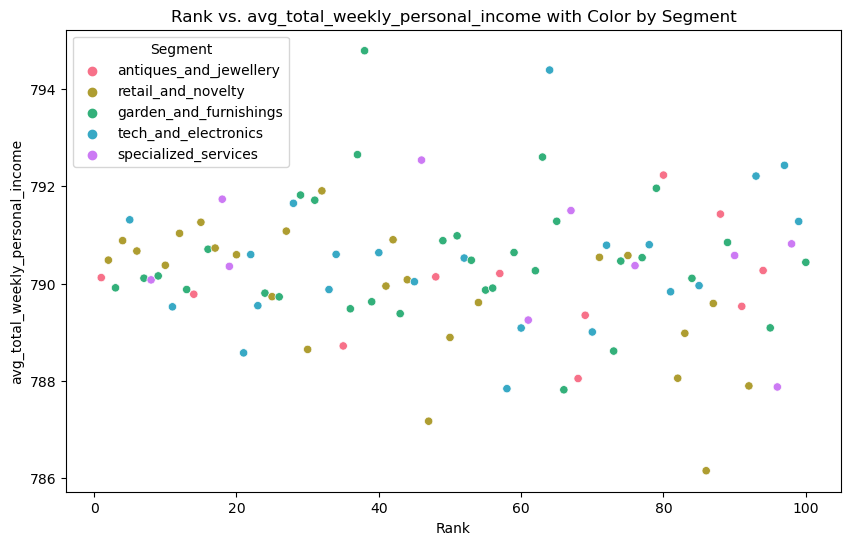

/Users/jackolivier/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jackolivier/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jackolivier/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jackolivier/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstan

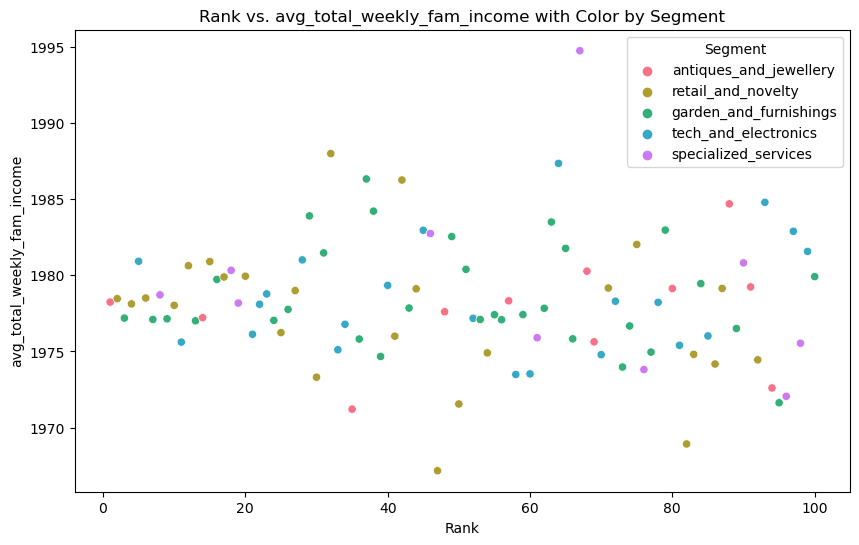

/Users/jackolivier/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jackolivier/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jackolivier/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jackolivier/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstan

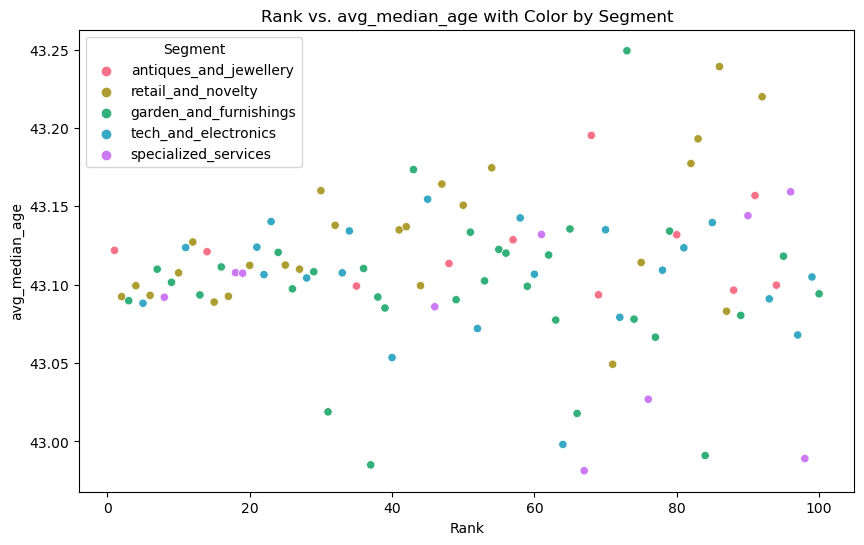

/Users/jackolivier/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jackolivier/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jackolivier/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jackolivier/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstan

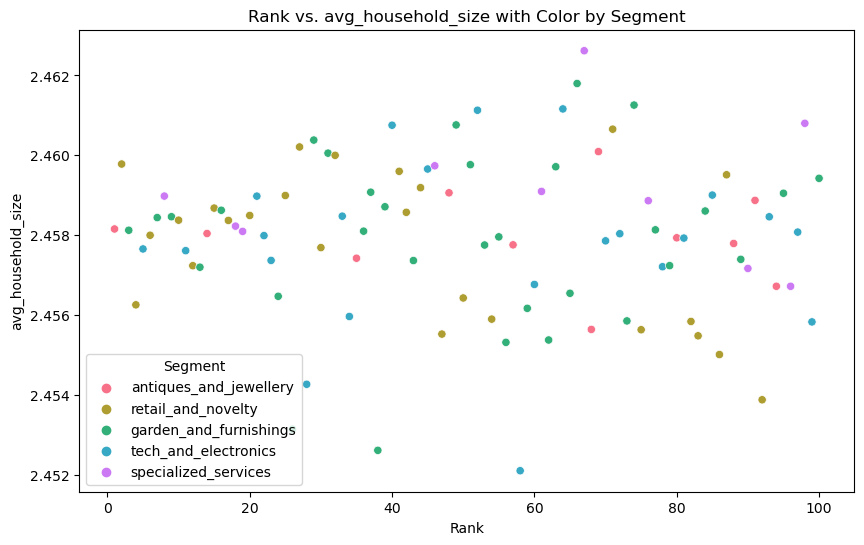

/Users/jackolivier/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jackolivier/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jackolivier/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jackolivier/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstan

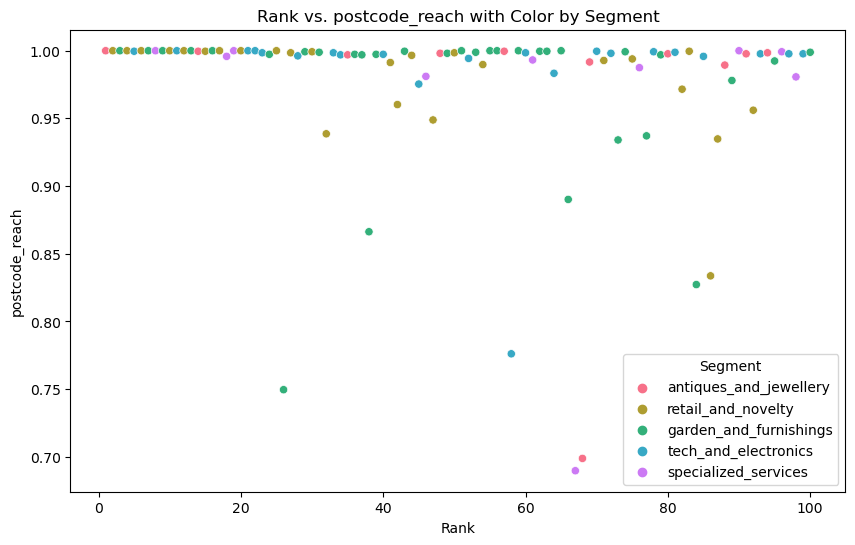

/Users/jackolivier/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jackolivier/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jackolivier/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jackolivier/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstan

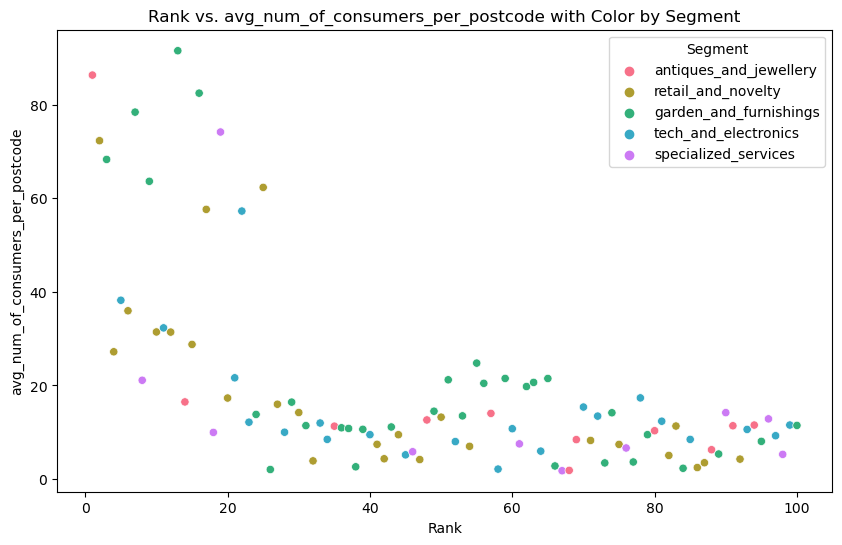

/Users/jackolivier/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jackolivier/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jackolivier/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jackolivier/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstan

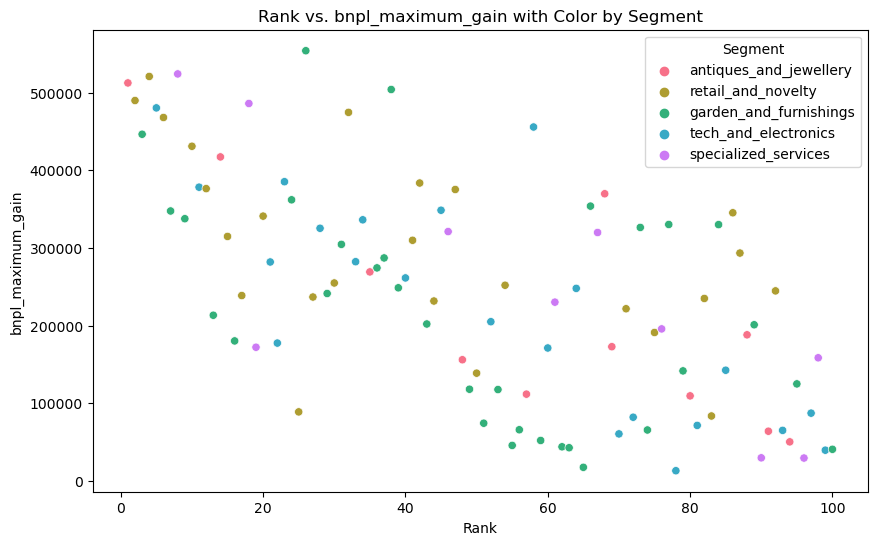

/Users/jackolivier/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jackolivier/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jackolivier/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jackolivier/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstan

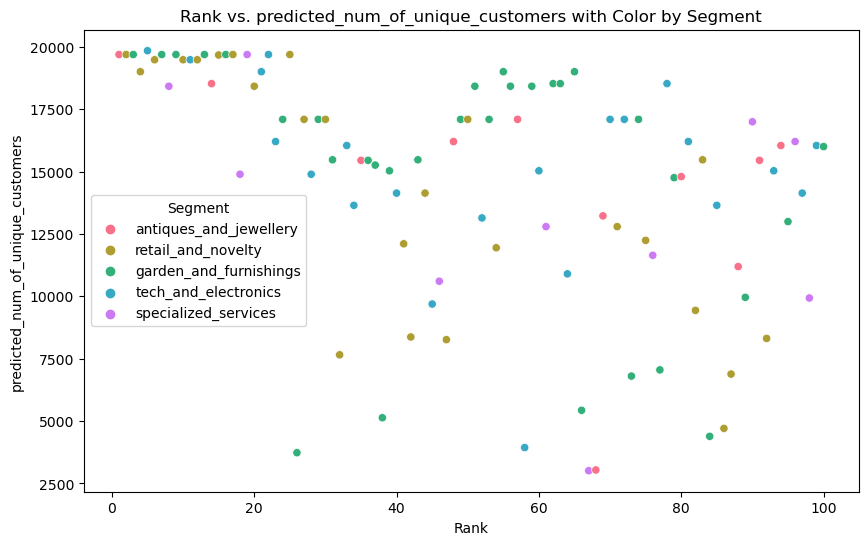

In [57]:
# Set the figure size
plt.figure(figsize=(12, 8))

# Define a color palette for the segments (adjust as needed)
palette = sns.color_palette("husl", n_colors=len(top_100_pandas['segment'].unique()))

# Create a separate scatter plot for each attribute
for attr in numerical_columns:
    plt.figure(figsize=(10, 6))
    
    # Create a scatter plot with different colors for each segment
    sns.scatterplot(data=top_100_pandas, x='rank', y=attr, hue='segment', palette=palette)
    
    # Add labels and a legend
    plt.xlabel('Rank')
    plt.ylabel(attr)
    plt.title(f'Rank vs. {attr} with Color by Segment')
    plt.legend(title='Segment')
    
    # Show the plot
    plt.show()

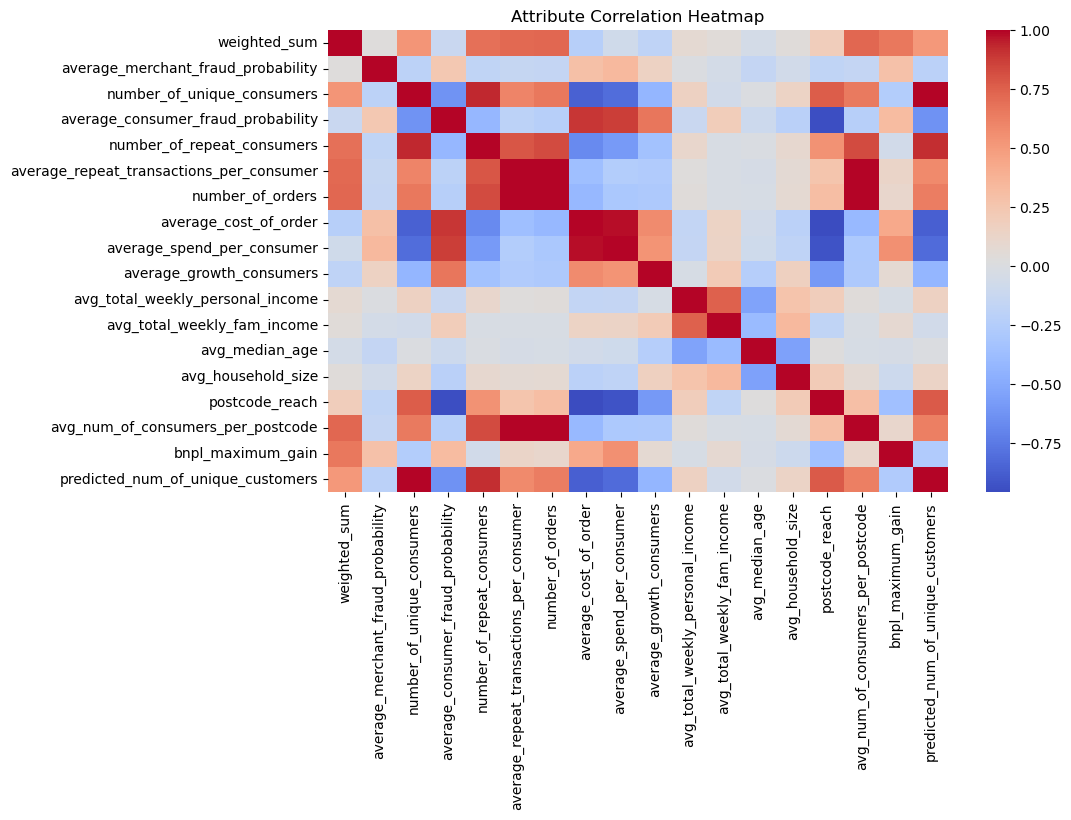

In [28]:
plt.figure(figsize=(10, 6))

correlation_matrix = top_100_pandas[numerical_columns].corr()


sns.heatmap(correlation_matrix, cmap="coolwarm")

plt.title('Attribute Correlation Heatmap')
plt.show()

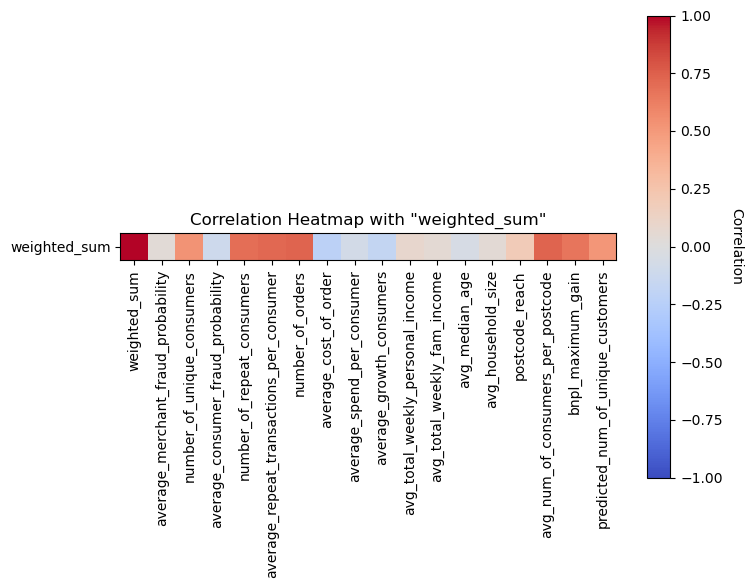

In [53]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'correlation_matrix' is your correlation matrix between 'weighted_sum' and other attributes
correlation_matrix = top_100_pandas[numerical_columns].corr().loc[['weighted_sum'], :]

# Set the figure size
plt.figure(figsize=(8, 6))

# Create a heatmap with Matplotlib using plt.imshow
plt.imshow(correlation_matrix, cmap="coolwarm", vmin=-1, vmax=1)

# Add a colorbar
cbar = plt.colorbar()
cbar.set_label('Correlation', rotation=270, labelpad=15)

# Set ticks and labels for both axes
plt.xticks(np.arange(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=90)
plt.yticks([0], ["weighted_sum"])

# Set the title
plt.title('Correlation Heatmap with "weighted_sum"')

# Show the plot
plt.show()


In [28]:
spark.stop()